# Species Clustering

Please refer to the synthetic species dataset (clustering_synthetic_dataset) in the Datasets directory. This dataset is composed of two features
belonging to observations that can be grouped into certain species. The goal is to refine the
data so that we can classify species together and use their features to classify new
observations.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from sklearn.cluster import KMeans
from scipy.spatial import distance
from sklearn.cluster import DBSCAN
from sklearn.metrics import accuracy_score
from typing import Callable, List, Tuple, Any, Dict
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from IPython.display import Image
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

### Helpers

<a id="k_fold"></a>
### k_fold

*The k_fold function runs k_fold validation using the provided model function or pipeline. The function outputs the average accuracy scores (with standard deviation) for the training and test sets.*

* **data** np.array: a dataset 
* **labels** List[str]: a list of feature names for the dataframe columns and rows
* **n_folds** int: the number of folds
* **pipeline** Callable: a callable model or pipeline

**returns** None

In [2]:
def k_fold(data: np.array, labels: List[str], n_folds: int, pipeline: Callable) -> None:
    train_accs, test_accs = [], []
    k_fold = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    for train_idx, test_idx in k_fold.split(data, labels):
        train_data, train_labels = data[train_idx], labels[train_idx]
        test_data, test_labels = data[test_idx], labels[test_idx]

        # train model
        pipeline.fit(train_data, train_labels)

        # make predictions
        train_predictions = pipeline.predict(train_data)
        test_predictions = pipeline.predict(test_data)

        # get evaluation metrics
        train_acc = round(100 * accuracy_score(train_labels, train_predictions), 2)
        test_acc = round(100 * accuracy_score(test_labels, test_predictions), 2)

        # append accuracies to results 
        train_accs.append(train_acc)
        test_accs.append(test_acc)


    print(f'10-fold CV Train Accuracy: {np.mean(train_accs):.3f} {chr(177)}{np.std(train_accs):.4f}')
    print(f'10-fold CV Test Accuracy: {np.mean(test_accs):.3f} {chr(177)}{np.std(test_accs):.4f}')
    print("\n")

In [3]:
# load dataset
data = pd.read_csv('Datasets/clustering_synthetic_dataset.csv')
data.head()

,f1,f2
0,0.494261,1.451067
1,-1.428081,-0.837064
2,0.338559,1.038759
3,0.119001,-1.053976
4,1.122425,1.774937


In [4]:
print(f"There are {len(data)} examples in the clustering dataset.")

There are 750 examples in the clustering dataset.


In [5]:
# check for null values
print(f"Missing values:\n{data.isnull().sum()}")

Missing values:
f1    0
f2    0
dtype: int64


### Cluster Exploration

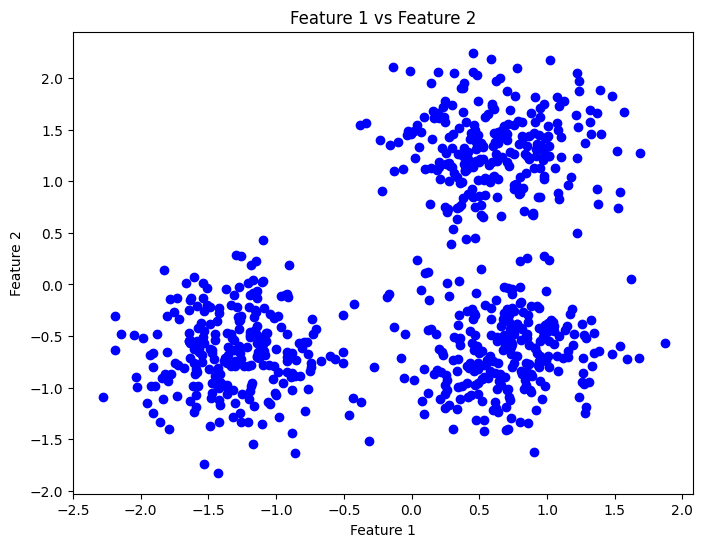

In [6]:
# plot the data
plt.figure(figsize=(8, 6))
plt.scatter(data['f1'], data['f2'], c='blue', marker='o')
plt.xticks(np.arange(-2.5, 2.5, 0.5))
plt.title('Feature 1 vs Feature 2')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

The scatterplot above shows three clear clusters. These clusters correspond to three species in the synthetic dataset.

The scatterplot above shows the following feature ranges for the three species:

**Species 1:** 
 - Range Feature 1: [(-2.3) - (-0.3)]
 - Range Feature 2: [(-1.75) - 0.5]
 
**Species 2:** 
 - Range Feature 1: [(-0.2) - 1.9]
 - Range Feature 2: [(-1.6) - 0.5]
 
**Species 3:** 
 - Range Feature 1: [0.3 - 1.75]
 - Range Feature 2: [0.55 - 2.25]


The following cell applies these feature ranges to color the scatterplot.

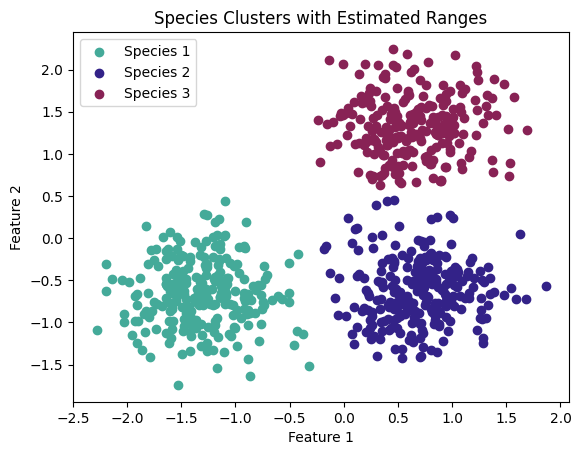

In [7]:
# define ranges for the three species clusters
clusters = [
    (data['f1'] >= -2.3) & (data['f1'] <= -0.3) & (data['f2'] >= -1.75) & (data['f2'] <= 0.5),
    (data['f1'] >= -0.2) & (data['f1'] < 1.9) & (data['f2'] >= -1.6) & (data['f2'] <= 0.5),
    (data['f1'] >= -0.3) & (data['f1'] < 1.75) & (data['f2'] >= 0.55) & (data['f2'] <= 2.25)
]

# set colors and labels
colors = ['#44AA99', '#332288', '#882255']
species_names = ["Species 1", "Species 2", "Species 3"]
# create a copy of the dataset to use for plotting the three species ranges
plot_data = deepcopy(data)
plot_data['species'] = np.select(clusters, species_names)
# plot the species ranges
for color, species in zip(colors, species_names):
    subset = plot_data[plot_data['species'] == species]
    plt.scatter(subset['f1'], subset['f2'], c=color, label=species)
plt.xticks(np.arange(-2.5, 2.5, 0.5))
plt.title('Species Clusters with Estimated Ranges')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

## Use K-means clustering to find anomalies

Number of outliers removed: 38


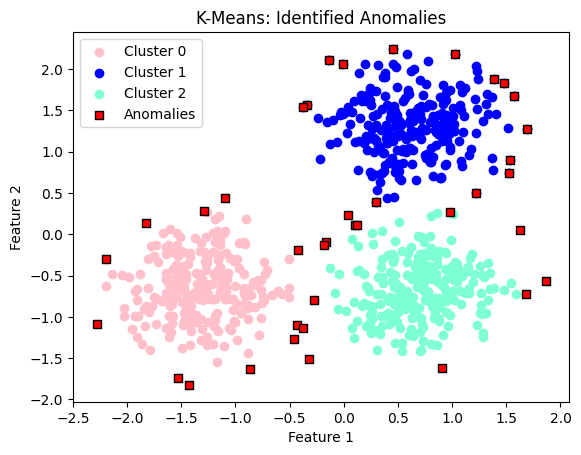

In [8]:
cluster_data = data.values

# run k-means with 3 clusters
km_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', KMeans(n_clusters=3, random_state=0))
])
km_pipeline.fit(cluster_data)
cluster_labels = km_pipeline.named_steps['model'].labels_
centroids = km_pipeline.named_steps['model'].cluster_centers_

# calculate the euclidean distances to cluster centeroids 
distances = []
for idx, cluster in enumerate(cluster_labels):
    dist = distance.euclidean(cluster_data[idx], centroids[cluster])
    distances.append([dist])
distances = np.array(distances)

# set a threshold and get anomalies
threshold = np.percentile(distances, 95)
boundary_points = data[distances > threshold]

# remove anomalies from the data and add cluster labels as species
km_df = deepcopy(data)
km_df['species'] = cluster_labels
km_cleaned_df = km_df[distances < threshold]

# print the number of outliers removed
print(f"Number of outliers removed: {len(km_df)-len(km_cleaned_df)}")

# plot the clusters
colors = ['pink', 'blue', 'aquamarine']
for i in range(3):
    plt.scatter(data[cluster_labels == i]['f1'], data[cluster_labels == i]['f2'], c=colors[i], marker='o', label=f'Cluster {i}')

# overlay the identified boundary points to show anomalies
plt.scatter(boundary_points['f1'], boundary_points['f2'], c='red', marker='s', edgecolor='k', label='Anomalies')

plt.xticks(np.arange(-2.5, 2.5, 0.5))
plt.title('K-Means: Identified Anomalies')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

The cell above used the k-means algorithm with k=3 to generate the three clusters. Next, the code calculated the Euclidean distance of each data point to its cluster centroid and used the 95th percentile of distances as the threshold to identify outliers outside this range. The plot shows the identified anomalies that were removed from the cleaned dataset. 

## Use DBSCAN clustering to find anomalies

Number of outliers removed: 91


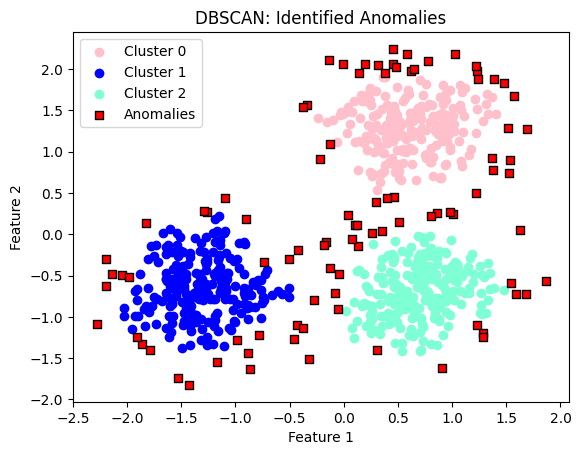

In [9]:
cluster_data = data.values

# use DBSCAN to find anomalies
dbscan_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', DBSCAN(eps=0.2, min_samples=10))
])
cluster_labels = dbscan_pipeline.named_steps['model'].fit_predict(cluster_data)
boundary_points = data[cluster_labels == -1]

# remove anomalies from the data and add cluster labels as species
dbscan_df = deepcopy(data)
dbscan_df['species'] = cluster_labels
dbscan_cleaned_df = dbscan_df[dbscan_df['species'] != -1]

# print the number of outliers removed
print(f"Number of outliers removed: {len(dbscan_df)-len(dbscan_cleaned_df)}")

# plot the clusters
colors = ['pink', 'blue', 'aquamarine']
for i in range(3):
    plt.scatter(data[cluster_labels == i]['f1'], data[cluster_labels == i]['f2'], c=colors[i], marker='o', label=f'Cluster {i}')

# overlay the identified boundary points to show anomalies
plt.scatter(boundary_points['f1'], boundary_points['f2'], c='red', marker='s', edgecolor='k', label='Anomalies')

plt.xticks(np.arange(-2.5, 2.5, 0.5))
plt.title('DBSCAN: Identified Anomalies')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

Unlike the K-Means algorithm, the DBSCAN algorithm does not require a pre-set number of clusters. The DBSCAN algorithm identifies regions of high density to form the clusters. Increasing the value of epsilon reduced the algorithm's sensitivity to outliers because this value defines the maximum distance for a point to be considered part of a cluster. Increasing the minimum number of samples increased the algorithm's sensitivity to outliers because this value describes how many points must be in a region to be considered a core point. Applying different parameter values with the DBSCAN algorithm drastically changed the results of outlier detection. With the above parameters, the two approaches produced similar results and successfully identified the boundary points of the clusters. 

## Visualize the cleaned and uncleaned data with a decision tree

In [10]:
km_cleaned_df.head()

,f1,f2,species
0,0.494261,1.451067,1
1,-1.428081,-0.837064,0
2,0.338559,1.038759,1
3,0.119001,-1.053976,2
4,1.122425,1.774937,1


In [11]:
km_cleaned_df.shape

(712, 3)

In [12]:
# split the labels
cleaned_data = km_cleaned_df.drop('species', axis=1)
cleaned_labels = km_cleaned_df['species']
# split the data
x_train, x_test, y_train, y_test = train_test_split(cleaned_data, cleaned_labels, test_size=0.2, random_state=42)
# create and fir the decision tree model
tree = DecisionTreeClassifier()
tree.fit(x_train, y_train)
# create a tree visualization using graphviz
dot_data = export_graphviz(tree,
                           out_file='species_tree.dot',
                           feature_names=cleaned_data.columns,
                           class_names=True,
                           filled=True,
                           rounded=True,
                           special_characters=True)
# convert to a png file for visualization
!dot -Tpng species_tree.dot -o species_tree.png -Gdpi=72

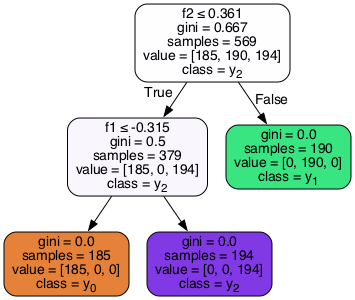

In [13]:
# visualize decision tree
Image(filename = 'species_tree.png')

The visualization shows that the decision tree trained on cleaned data is simple and interpretable. Due to outlier removal, the values used for feature splits differ slightly from the ranges specified in problem two.

In [14]:
tree = DecisionTreeClassifier()

# Run 10-fold validation with uncleaned k_means data
km_data = np.array(km_df.drop('species', axis=1))
km_labels = np.array(km_df['species'])

k_fold(km_data, km_labels, 10, tree)

10-fold CV Train Accuracy: 100.000 ±0.0000
10-fold CV Test Accuracy: 99.467 ±0.8846




In [15]:
# Run 10-fold validation with cleaned k_means data
km_cleaned_data = np.array(km_cleaned_df.drop('species', axis=1))
km_cleaned_labels = np.array(km_cleaned_df['species'])

k_fold(km_cleaned_data, km_cleaned_labels, 10, tree)

10-fold CV Train Accuracy: 100.000 ±0.0000
10-fold CV Test Accuracy: 100.000 ±0.0000




In [16]:
# split the labels for the uncleaned data
data = km_df.drop('species', axis=1)
labels = km_df['species']
# split the data
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
# fit the model
tree.fit(x_train, y_train)
# visualize the tree trained on unclean data
dot_data = export_graphviz(tree,
                           out_file='uncleaned_tree.dot',
                           feature_names=cleaned_data.columns,
                           class_names=True,
                           filled=True,
                           rounded=True,
                           special_characters=True)
# convert to a png file for visualization
!dot -Tpng uncleaned_tree.dot -o uncleaned_tree.png -Gdpi=72

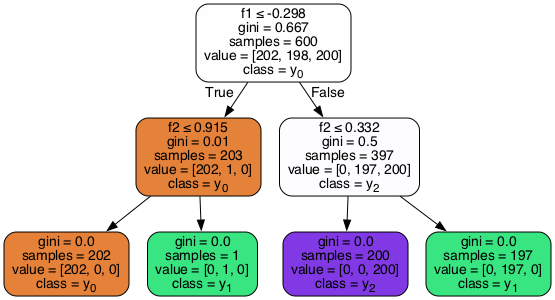

In [17]:
Image(filename = 'uncleaned_tree.png')

The results of 10-fold validation on the cleaned and uncleaned versions of the k-means dataset showed only a slight increase in accuracy between the two models. However, the visualization of both trees shows that the outlier data produced a more complex model due to the tree adding additional feature splits for the outliers. The simpler model is more interpretable and will generalize better to new examples.